In [1]:
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.map import Map
from sunpy.coordinates import frames
from sunpy.net import hek
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon
from astropy.coordinates import SkyCoord
from skimage import measure
import numpy as np
import numpy.ma as ma
from PIL import Image

/Users/reza/Career/DMLab/AR TRACKING/ar-track/src/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/reza/Career/DMLab/AR TRACKING/ar-track/src/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_noaa_active_regions(magnetogram_time):
    active_regions = hek_client.search(
        a.Time(
            magnetogram_time, magnetogram_time + 1 * u.minute
        ),  # Exact match to magnetogram time
        hek.attrs.EventType("AR"),
    )
    return active_regions

In [8]:
start_date = "2024-09-01"
end_date = "2024-09-02"
results = Fido.search(
    a.Time(start_date, end_date),
    a.Instrument.hmi,
    a.Physobs.los_magnetic_field,
    a.Sample(1 * u.hour),
)
files = Fido.fetch(results)
hek_client = hek.HEKClient()

Files Downloaded:   0%|          | 0/24 [00:00<?, ?file/s]









Files Downloaded:   4%|▍         | 1/24 [00:04<01:38,  4.26s/file]












































































































































































































































Files Downloaded:   8%|▊         | 2/24 [00:08<01:31,  4.17s/file]














Files Downloaded:  12%|█▎        | 3/24 [00:08<00:49,  2.35s/file]





















































































Files Downloaded:  17%|█▋        | 4/24 [00:09<00:38,  1.93s/file]























Files Downloaded:  21%|██        | 5/24 [00:10<00:27,  1.42s/file]

















































































































































































































































10/0 files failed to download. Please check `.errors` for details


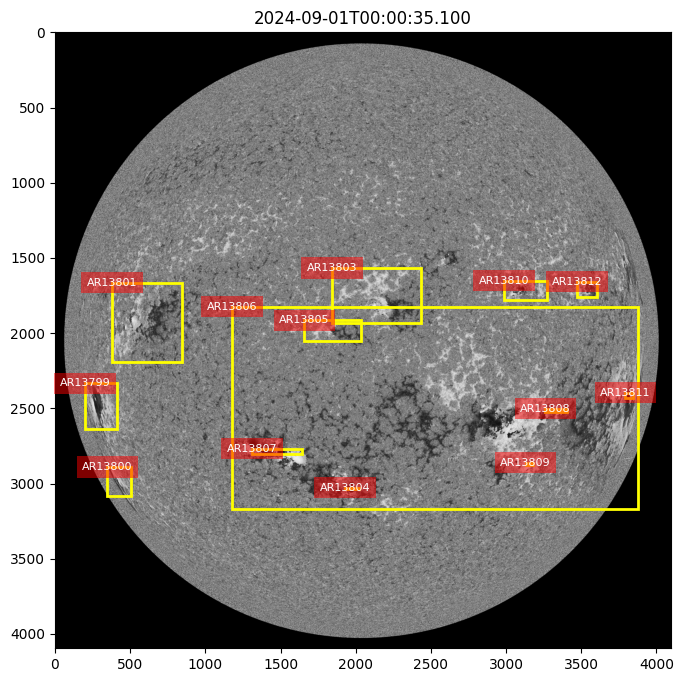

In [7]:
for file in files:
        magnetogram = Map(file)
        observer = magnetogram.observer_coordinate

        # Plot the magnetogram
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot()
        data = magnetogram.data
        valid_mask = ~np.isnan(data)
        biased_data = np.abs(data) + 1

        log_scaled_data = np.log(biased_data)

        log_scaled_data[data < 0] *= -1

        mean_value = np.mean(log_scaled_data[valid_mask])
        std_dev = np.std(log_scaled_data[valid_mask])
        scaled = np.zeros_like(data, dtype=np.float32)
        scaled[valid_mask] = (log_scaled_data[valid_mask] - mean_value) / std_dev
        min, max = scaled[valid_mask].min(), scaled[valid_mask].max()
        scaled[valid_mask] = (scaled[valid_mask] - min) / (max - min)
        scaled = (scaled * 255).astype(np.uint8)

        img = Image.fromarray(scaled)
        img.save(f"{magnetogram.date}.jpg")
        ax.imshow(scaled, cmap="gray")
        ax.set_title(magnetogram.date)

        active_regions = get_noaa_active_regions(magnetogram.date)
        rectangles = dict()
        for region in active_regions:
            if region["ar_noaanum"] is None:
                continue
            hpc_coords = [
                tuple(map(float, point.split()))
                for point in region["hpc_bbox"]
                .replace("POLYGON((", "")
                .replace("))", "")
                .split(",")
            ]
            hpc_vertices = SkyCoord(
                [x[0] for x in hpc_coords] * u.arcsec,
                [x[1] for x in hpc_coords] * u.arcsec,
                frame="helioprojective",
                observer=observer,
            )
            pixel_coords = magnetogram.world_to_pixel(hpc_vertices)
            min_x, min_y = pixel_coords.x.min().value, pixel_coords.y.min().value
            max_x, max_y = pixel_coords.x.max().value, pixel_coords.y.max().value
            if region['ar_noaanum'] in rectangles:
                rectangles[region["ar_noaanum"]].append((min_x, min_y, max_x - min_x, max_y - min_y))
            else:
                rectangles[region["ar_noaanum"]] = [(min_x, min_y, max_x - min_x, max_y - min_y)]

        rectangles = {ar_num: sorted(rectangles[ar_num], key=lambda bbox: bbox[2] * bbox[3], reverse=True)[0] for ar_num in rectangles}

        for ar_num in rectangles:
            min_x, min_y, width, height = rectangles[ar_num]
            rect = Rectangle(
                (min_x, min_y),
                width,
                height,
                edgecolor="yellow",
                facecolor="none",
                lw=2,
            )
            ax.add_patch(rect)
            ax.text(
                min_x,
                min_y,
                f"AR{ar_num}",
                color="white",
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(facecolor="red", alpha=0.5, lw=0),
            )
        plt.show()
